In [99]:
import pandas as pd
import os
import glob

directory = 'ata'

files = glob.glob(os.path.join(directory, '* image ratings.xlsx'))

dataframes = []
missing_rows_log = []
 
def to_tuple(value):

    if isinstance(value, (int, float)):
        return (value,)
    elif isinstance(value, str):
        return tuple(map(str.strip, value.split(',')))
    return (value,)

# Loop through each file
for file in files:
   
    rater = str.upper(file.split('/')[-1].split(' ')[0]) # based on file name i.e.: 'final Rater1 image ratings - decoding fatphobia.xlsx'

    excel_file = pd.ExcelFile(file)
    
     # Loop through each sheet in the file
    for sheet_name in excel_file.sheet_names:
#         # Read the sheet data, handling variable number of columns
        df = pd.read_excel(file, sheet_name=sheet_name, skiprows=2)
#         print(sheet_name, "rows: ")
        # Ensuring we have the correct number of columns
        if df.shape[1] == 4:
            df.columns = ["Photo #", "Weight (1-10)", "Gender", "Race"]
            df["Notes"] = ""
        elif df.shape[1] == 5:
            df.columns = ["Photo #", "Weight (1-10)", "Gender", "Race", "Notes"]
        else:
            continue
        
        df["Weight (1-10)"] = df["Weight (1-10)"].apply(to_tuple)
        df["Gender"] = df["Gender"].apply(to_tuple)
        df["Race"] = df["Race"].apply(to_tuple)
        
        df["RATER"] = rater
        df["LABEL"] = sheet_name

        dataframes.append(df)

final_df = pd.concat(dataframes, ignore_index=True)
final_df = final_df[['RATER', 'LABEL', 'Photo #', "Weight (1-10)", "Gender", "Race"]]
cleaned_df = final_df.copy()

cleaned_df['WeightRate_Person1'] = cleaned_df['Weight (1-10)'].map(lambda x: float(x[0]))
cleaned_df['WeightRate_Person2'] = cleaned_df['Weight (1-10)'].map(lambda x: float(x[1]) if len(x)>1 else pd.NA)
cleaned_df['Gender_Person1'] = cleaned_df['Gender'].map(lambda x: x[0])
cleaned_df['Gender_Person2'] = cleaned_df['Gender'].map(lambda x: x[1] if len(x)>1 else pd.NA)
cleaned_df['Race_Person1'] = cleaned_df['Race'].map(lambda x: x[0])
cleaned_df['Race_Person2'] = cleaned_df['Race'].map(lambda x: x[1] if len(x)>1 else pd.NA)

cleaned_df.drop(['Weight (1-10)', 'Gender', 'Race'], axis=1, inplace=True)

consolidated = cleaned_df.groupby(['LABEL','Photo #'])[["WeightRate_Person1",'WeightRate_Person2','Gender_Person1','Gender_Person2','Race_Person1','Race_Person2']].agg({
                    'WeightRate_Person1': pd.Series.mean,
                    'WeightRate_Person2': pd.Series.mean,
                    'Gender_Person1': pd.Series.mode,
                    'Gender_Person2': pd.Series.mode,
                    'Race_Person1': pd.Series.mode,
                    'Race_Person2': pd.Series.mode
                }).reset_index()

consolidated.to_excel(os.path.join(directory, 'consolidated.xlsx'), index=False)

print("Data combined successfully!")

Data combined successfully!


In [1]:
import numpy as np
import pandas as pd

def weight_category(weight):
    if weight < 3:
        return 'UW'
    elif weight < 6:
        return 'NORMAL'
    elif weight < 8:
        return 'OV'
    elif weight < 11:
        return 'OB'

df = pd.read_excel('/Users/femartinez/Documents/Research/DecodingFatphobia/data/consolidated-final.xlsx')
df['LABEL_POS_NEG'] = df['LABEL'].map(lambda x: x[0])
df['LABEL_N'] = df['LABEL'].map(lambda x: int(x[1:].split('-')[0]))
df['WeightRate_Person'] = df[['WeightRate_Person1', 'WeightRate_Person2']].mean(axis=1)
df['WeightCategory_Person1'] = df['WeightRate_Person1'].apply(weight_category)
df['WeightCategory_Person2'] = df['WeightRate_Person2'].apply(weight_category)

In [2]:
# PER LABEL ANALYSIS

wc1 = df.pivot_table(index='LABEL', columns='WeightCategory_Person1', aggfunc='size', fill_value=0)
wc2 = df.pivot_table(index='LABEL', columns='WeightCategory_Person2', aggfunc='size', fill_value=0)

wc1_ = wc1.reindex(index=wc1.index.union(wc2.index), columns=wc1.columns.union(wc2.columns), fill_value=0)
wc2_ = wc2.reindex(index=wc1.index.union(wc2.index), columns=wc1.columns.union(wc2.columns), fill_value=0)
wc1, wc2 = wc1_, wc2_
wcs = wc1 + wc2
wcs['PEOPLE'] = wcs.sum(axis=1)
wcs_pct = wcs.drop('PEOPLE', axis=1).div(wcs.drop('PEOPLE', axis=1).sum(axis=1),axis=0).add_prefix('pct_')

per_label = df.groupby('LABEL').agg(
                            POS_NEG=('LABEL_POS_NEG', 'unique'),
                            N=('LABEL_N', 'unique'),
                            AVG_weightRate_Person=('WeightRate_Person', 'mean'),
                            MIN_weightRate_Person=('WeightRate_Person', 'min'),
                            MAX_weightRate_Person=('WeightRate_Person', 'max')
                             ).fillna(0).\
                             merge(wcs, left_index=True, right_index=True).\
                             merge(wcs_pct, left_index=True, right_index=True).fillna(0)

per_label['POS_NEG'], per_label['N'] = per_label['POS_NEG'].map(lambda x: x[0]), per_label['N'].map(lambda x: int(x[0]))

per_label.sort_values(by=['POS_NEG', 'N'], ascending=True)

,POS_NEG,N,AVG_weightRate_Person,MIN_weightRate_Person,MAX_weightRate_Person,NORMAL,OB,OV,UW,PEOPLE,pct_NORMAL,pct_OB,pct_OV,pct_UW
LABEL,,,,,,,,,,,,,,
N1-undignified,N,1,3.703750,2.00,8.75,76,2,5,18,101,0.752475,0.019802,0.049505,0.178218
N2-disgusting,N,2,3.310833,1.50,5.00,74,0,0,26,100,0.740000,0.000000,0.000000,0.260000
N3-undisciplined,N,3,3.802500,2.50,8.75,86,1,2,11,100,0.860000,0.010000,0.020000,0.110000
N4-sinful,N,4,3.612500,1.75,5.75,94,0,0,6,100,0.940000,0.000000,0.000000,0.060000
N5-gluttonous,N,5,6.602500,2.25,10.00,46,42,10,2,100,0.460000,0.420000,0.100000,0.020000
N6-lazy,N,6,4.577500,2.75,10.00,77,6,12,5,100,0.770000,0.060000,0.120000,0.050000
N7-greedy,N,7,4.541667,3.00,10.00,88,10,2,0,100,0.880000,0.100000,0.020000,0.000000
N8-unhealthy,N,8,3.375833,1.00,10.00,32,11,3,54,100,0.320000,0.110000,0.030000,0.540000
N9-immoral,N,9,3.711667,2.75,5.00,99,0,0,2,101,0.980198,0.000000,0.000000,0.019802


In [3]:
# PER GENDER ANALYSIS
gender_person1_df = df.groupby('LABEL_POS_NEG').Gender_Person1.value_counts().unstack(fill_value=0)
gender_person2_df = df.groupby('LABEL_POS_NEG').Gender_Person2.value_counts().unstack(fill_value=0)

per_gender = gender_person1_df.add(gender_person2_df, fill_value=0).drop(' ',axis=1)

genders = per_gender.columns
mean_weight_rate = []

for pn in per_gender.index:
    for g in genders:
        mean_val = float(pd.concat(
            [df[(df['LABEL_POS_NEG'] == pn) & (df['Gender_Person1'] == g)]['WeightRate_Person1'],
             df[(df['LABEL_POS_NEG'] == pn) & (df['Gender_Person2'] == g)]['WeightRate_Person2']],
            axis=0
        ).mean())
        
        mean_weight_rate.append(mean_val)

mean_weight_rate_df = pd.DataFrame(
    np.array(mean_weight_rate).reshape(per_gender.shape),
    index=per_gender.index,
    columns=genders
)

per_gender = pd.concat([per_gender, 
                        mean_weight_rate_df.add_prefix('avg_weight_'),
                        per_gender[genders].div(per_gender[genders].sum(axis=1), axis=0).add_prefix('pct_')], 
                        axis=1)
per_gender

,F,M,N,avg_weight_F,avg_weight_M,avg_weight_N,pct_F,pct_M,pct_N
LABEL_POS_NEG,,,,,,,,,
N,208,1791,6.0,3.225962,3.869021,2.25,0.103741,0.893267,0.002993
P,852,1166,5.0,2.731416,3.641152,3.35,0.421157,0.576372,0.002472


In [4]:
# PER RACE
race_person1_df = df.groupby('LABEL_POS_NEG').Race_Person1.value_counts().unstack(fill_value=0)
race_person2_df = df.groupby('LABEL_POS_NEG').Race_Person2.value_counts().unstack(fill_value=0)

per_race = race_person1_df.add(race_person2_df, fill_value=0)

races = per_race.columns
mean_weight_rate = []

for pn in per_race.index:
    for g in races:
        mean_val = float(pd.concat(
            [df[(df['LABEL_POS_NEG'] == pn) & (df['Race_Person1'] == g)]['WeightRate_Person1'],
             df[(df['LABEL_POS_NEG'] == pn) & (df['Race_Person2'] == g)]['WeightRate_Person2']],
            axis=0
        ).mean())
        
        mean_weight_rate.append(mean_val)

mean_weight_rate_df = pd.DataFrame(
    np.array(mean_weight_rate).reshape(per_race.shape),
    index=per_race.index,
    columns=races
)

per_race = pd.concat([per_race, 
                        mean_weight_rate_df.add_prefix('avg_'),
                        per_race[races].div(per_race[races].sum(axis=1), axis=0).add_prefix('pct_')],
                        axis=1)
per_race.T

LABEL_POS_NEG,N,P
asian,222.000000,345.000000
black,45.000000,90.000000
latino,17.000000,23.000000
middle eastern,162.000000,213.000000
mixed,49.000000,73.000000
nonwhite,158.000000,166.000000
pacific islander/indigenous,2.000000,1.000000
undetermined,98.000000,16.000000
white,1252.000000,1096.000000
avg_asian,3.582207,2.978261


In [5]:
# T-Test (2-tailed)
from scipy.stats import ttest_ind

ttest_results = {}
for n in np.sort(df.LABEL_N.unique()):
    t_N = pd.concat([df[(df.LABEL_N == n) & (df.LABEL_POS_NEG == 'N')]['WeightRate_Person1'],df[(df.LABEL_N == n) & (df.LABEL_POS_NEG == 'N')]['WeightRate_Person2']], axis=0)
    t_P = pd.concat([df[(df.LABEL_N == n) & (df.LABEL_POS_NEG == 'P')]['WeightRate_Person1'],df[(df.LABEL_N == n) & (df.LABEL_POS_NEG == 'P')]['WeightRate_Person2']], axis=0)
    ttest_results[int(n)] = float((ttest_ind(t_N, t_P, nan_policy='omit')).pvalue/2)

pd.DataFrame(ttest_results, index=['p']).T

,p
1,2.549204e-03
2,1.574540e-01
3,2.032371e-02
4,5.831685e-05
5,8.124865e-27
6,9.589458e-15
7,2.547413e-15
8,2.655153e-01
9,4.587172e-04
10,9.452861e-17


In [14]:
# POS NEG TOTAL ANALYSIS

person1_columns = ['WeightRate_Person1', 'WeightSTD_Person1', 'Gender_Person1', 'Race_Person1', 'WeightCategory_Person1']
person2_columns = ['WeightRate_Person2', 'WeightSTD_Person2', 'Gender_Person2', 'Race_Person2', 'WeightCategory_Person2']

df_person1 = df[['LABEL', 'LABEL_POS_NEG'] + person1_columns].copy()
df_person1.columns = ['LABEL', 'LABEL_POS_NEG', 'WeightRate', 'WeightSTD', 'Gender', 'Race', 'WeightCategory']

df_person2 = df[['LABEL', 'LABEL_POS_NEG'] + person2_columns].copy()
df_person2.columns = ['LABEL', 'LABEL_POS_NEG', 'WeightRate', 'WeightSTD', 'Gender', 'Race', 'WeightCategory']
df_combined = pd.concat([df_person1, df_person2], axis=0)

people_count = df_combined.groupby('LABEL_POS_NEG').WeightRate.count()
avg_weight = df_combined.groupby('LABEL_POS_NEG').WeightRate.mean()
min_weight = df_combined.groupby('LABEL_POS_NEG').WeightRate.min()
max_weight = df_combined.groupby('LABEL_POS_NEG').WeightRate.max()

weight_category_counts = df_combined.pivot_table(index='LABEL_POS_NEG', columns='WeightCategory', aggfunc='size', fill_value=0)

aggregated_df = pd.DataFrame({
    '# PEOPLE': people_count,
    'AVG WEIGHT': avg_weight,
    'MIN WEIGHT': min_weight,
    'MAX WEIGHT': max_weight
})

aggregated_df = aggregated_df.join(weight_category_counts)

def pie_plot(data, label, title):
    plot_data = 100 * data.loc[label, ['UW', 'NORMAL', 'OV', 'OB']] / aggregated_df.loc['N', ['UW', 'NORMAL', 'OV', 'OB']].sum()
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = ['#FF6F61', '#FDBF6F', '#77DD77', '#89CFF0']
    explode = (0.07, 0.07, 0.07, 0.07)

    def func(pct):
        return f'{int(round(pct))}%'

    _, texts, autotexts = ax.pie(plot_data, 
                                    labels=['Underweight', 'Normal', 'Overweight', 'Obese'],
                                    autopct=func, startangle=90,
                                    colors=colors, textprops={'fontsize': 12, 'weight': 'bold'},
                                    pctdistance=0.85, explode=explode)
    for i, text in enumerate(texts):
        if plot_data.iloc[i] == 0:
            text.set_text('')
        text.set_fontsize(17)
    for i, autotext in enumerate(autotexts):
        if plot_data.iloc[i] == 0:
            autotext.set_text('')
        autotext.set_fontsize(25)
    ax.set_title(title, fontdict={'fontsize': 20, 'weight': 'bold'})
    plt.tight_layout()
    plt.show()

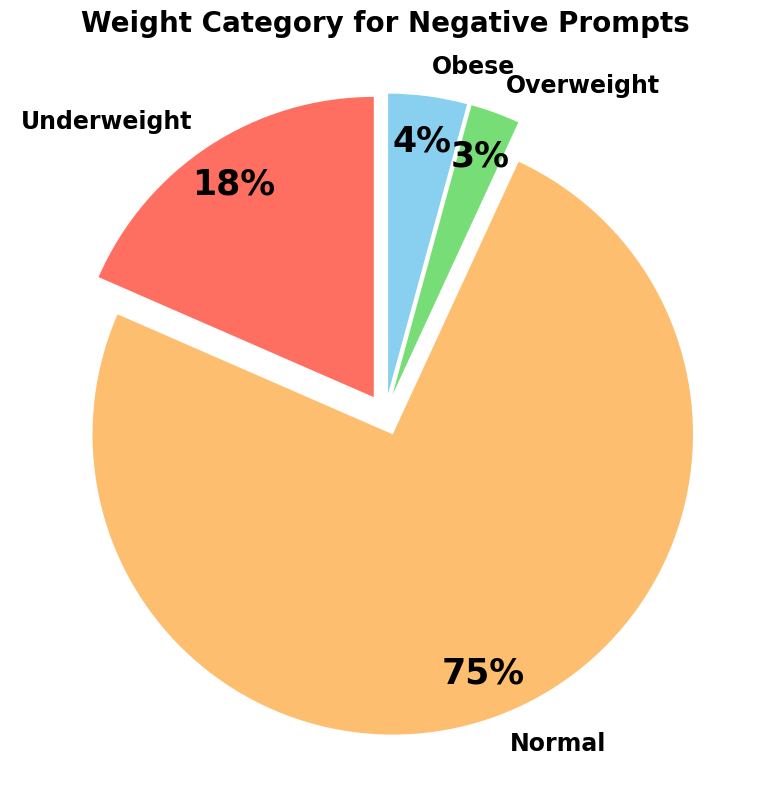

In [82]:
pie_plot(aggregated_df, 'N', 'Weight Category for Negative Prompts');

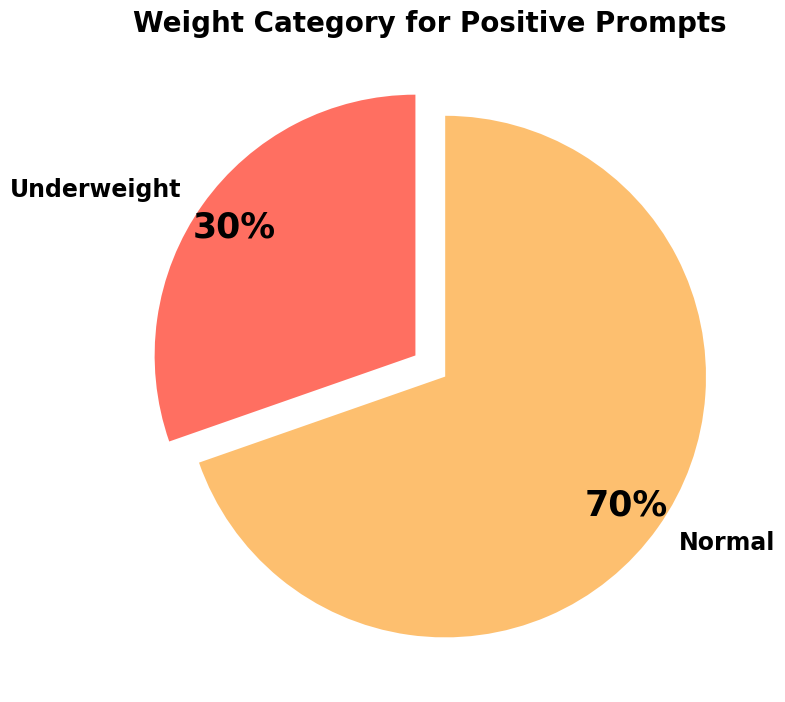

In [83]:
pie_plot(aggregated_df, 'P', 'Weight Category for Positive Prompts');